# 01 - Feature Extraction and Unsupervised Clustering for Medical Images

This notebook is the first phase of the semi-supervised learning workflow.

It covers:
- extracting feature vectors with a pretrained CNN,
- preprocessing embeddings for downstream analysis,
- exploratory unsupervised analysis (PCA, t-SNE),
- training and evaluating clustering models (KMeans, DBSCAN).

These steps structure the data space before applying semi-supervised methods in the next notebook.


In [1]:
import sys
from pathlib import Path
# Ajouter src/ au PYTHONPATH
sys.path.append(str(Path("..") / "src"))

P_DATA_PROC = "/workspace/data/labeled"
P_EMB = "/workspace/models"

IMG_SIZE = 224
BATCH_SIZE = 32
BACKBONE = "resnet18"

## A - Feature extraction (embeddings)

We extract embeddings from a pretrained convolutional model (e.g., ResNet18) used as a feature extractor. Each image is converted into a vector that captures visual characteristics.

These embeddings are reused for clustering and semi-supervised classification. We save embeddings, labels, and image paths to `.npy` files so we do not reprocess images each run.


In [2]:
from src.cnn_features import (
    pick_device,
    get_transform,
    build_dataloader,
    build_model,
    extract_embeddings,
    save_embeddings
)

# Detect GPU if available (fallback to CPU)
device = pick_device()

# Prepare image transforms (resize, normalization, etc.)
transform = get_transform(IMG_SIZE)

# Load images from the source folder in batches (create the DataLoader)
loader = build_dataloader(P_DATA_PROC, batch_size=BATCH_SIZE, transform=transform)

# Load the ResNet18 model
model = build_model(backbone=BACKBONE, device=device)

# Run images through the model and extract embeddings
features, labels, paths = extract_embeddings(model, loader, device=device)

# Sauvegarde dans features.npy, labels.npy, paths.npy
save_embeddings(P_EMB, features, labels, paths)

[INFO] No weights enum found for resnet18, using randomly initialized weights.


## B - Preprocessing for clustering

Extracted features often need scaling or dimensionality reduction before clustering. We apply a StandardScaler and then PCA.


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Dimensionality reduction (2 principal components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## C - Unsupervised analysis

We visualize reduced embeddings via PCA to detect potential groupings or anomalies without using labels.


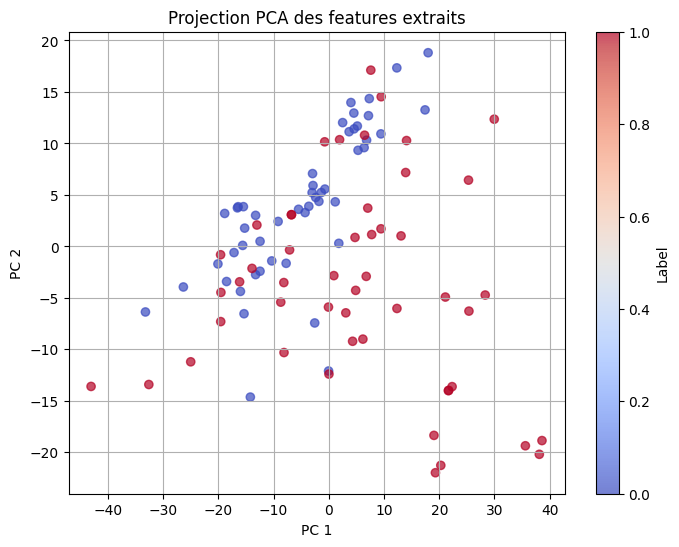

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("Projection PCA des features extraits")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.colorbar(scatter, label="Label")
plt.show()

#### Interpreting clusters

The clustering analysis shows multiple groups of visually similar images.

- Some classes appear well separated (dense, distinct clusters).
- Other clusters are diffuse, which can indicate:
  - visually similar classes, or
  - limited discriminative power in the extracted features.

Without human labels, cluster quality is hard to validate. A manual or semi-automatic review is often required.


## D - Training clustering models

We apply clustering algorithms (KMeans, DBSCAN) to identify similar groups. The goal is to find exploitable clusters for semi-supervised learning.

#### Hyperparameter choices

- **KMeans**:
  - `n_clusters` ideally matches the number of classes (if known).
  - Here we try `n_clusters = 10` as a simple hypothesis.
  - This can be tuned using the silhouette score or within-cluster distortion.

- **DBSCAN**:
  - `eps` controls neighborhood radius.
  - `min_samples` sets the minimum points for a cluster.
  - DBSCAN handles irregular cluster shapes but is sensitive to scale, so standardization/PCA helps.


In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# KMeans avec 2 clusters (par exemple pour normal / cancer)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Optional evaluation if labels are known
ari = adjusted_rand_score(labels, clusters)
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.0306


> A score close to 0 suggests KMeans does not recover the true class structure (normal vs. cancer). The result is only marginally better than random.

#### KMeans vs DBSCAN

- **KMeans**:
  - Fast to train.
  - Requires known `n_clusters`.
  - Assumes spherical, equally sized clusters.

- **DBSCAN**:
  - Does not require `n_clusters`.
  - Can detect irregular shapes and outliers.
  - Less robust when densities vary widely.

Depending on data structure, one method may be more suitable. Visual comparison and metrics like silhouette score help.


## Toward a semi-supervised approach

Clusters from KMeans/DBSCAN provide a first structuring step without labels.

In the next notebook, we use these results to start pseudo-labelling: some images are treated as labeled based on their cluster assignments, then a supervised model is trained on this enriched dataset.

This transition is key in semi-supervised workflows, where approximate labels bootstrap stronger generalization.


## Conclusion

We extracted feature vectors with a pretrained CNN and used them for exploratory unsupervised analysis. PCA/t-SNE visualizations revealed some latent structure but also overlap between classes.

Clustering with KMeans and DBSCAN produced groupings, but performance remained limited (e.g., ARI around 0.11), highlighting the limits of purely unsupervised methods.

These results motivate the semi-supervised approach in the next notebook, where a small labeled subset is used to guide learning across unlabeled data via pseudo-labelling.
